In [8]:
#**********************************************************************************
#Fuction to create cross-sections using ICON native grid
#
#Julian Quimbayo Duarte
#Goethe Uni, 2022
#quimbayo-duarte@iau.uni-frankfurt.de
#**********************************************************************************
#--modules
import time
import xarray as xr

import numpy as np
import numpy.ma as ma

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from   matplotlib.collections import PolyCollection

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from   cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

import math
import csv  

from scipy import interpolate
from scipy.interpolate import griddata
import sys
import datetime as dt

# First Party
sys.path.append('../utilities_tlezuo/')
# from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import get_stations_timeseries as gs

In [9]:

#*************************************************************************************************
#-- function to get the closer gp to coordinate
def get_indices(lats,lons,radius,LATX , LONX ):
    """ get_indices takes latitude latx and longitude lonx and
    returns the indices indexi and indexj of the nearest grid cell in a 2D array"""
    DISTANCE_TO_X = np.sqrt((lats - LATX)**2 + (lons - LONX)**2)
    indices = np.where(DISTANCE_TO_X < radius )
    return indices[0]
    pass
#*************************************************************************************************
#-- GEt the distance between two points
def haversine(lat1, lon1, lat2, lon2):
    rad=math.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(math.sin(rad*dlat/2))**2 + math.cos(rad*lat1)*math.cos(rad*lat2)*(math.sin(rad*dlon/2))**2
    distancia=2*R*math.asin(math.sqrt(a))
    return distancia
#*************************************************************************************************
#-- Getting the cross-section from the native ICON grid (only one interpolation)
#-- initial and final point for the cross-section

def cross_section(A, B, Step, with_file, icon_gp_file,clon,clat,dx,topo,var,z,interp_meth):
    #-- def some arrays
    X = np.empty(10000)
    Y = np.empty(10000)

    #-- Def the line and points between coordinates (A and B points)
    #-- geo points start and end
    x1, y1 = A
    x2, y2 = B

    #-- the increment step (higher = faster)
    STEP = Step #-- Step between points
    
    # print(str(x1),str(x2))
    if x1 > x2:           # x2 must be the bigger one here
        x1, x2 = x2, x1
        y1, y2 = y2, y1
    #-- getting the diff coordinates
        for i in range(int((x2-x1)/STEP) + 1):
            #print(i)
            x = x1 + i*STEP
            X[i] = x
            y = (y1-y2)/(x1-x2) * (x - x1) + y1
            Y[i] = y
    elif x1 == x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        for i in range(int((y2-y1)/STEP) + 1):
            y = y1 + i*STEP
            Y[i] = y
            x = x1
            X[i] = x
        
    #-- storing the coordinates in an array
    coords_in_line = np.empty([i+1,2])
    coords_in_line[:-1,1] = X[:i]
    coords_in_line[:-1,0] = Y[:i]
#
    #-- cross section lat lon points
    coords_in_line[-1,1] = B[0]
    coords_in_line[-1,0] = B[1]
    print('length of points array is '+str(len(coords_in_line)))

    #-- saving the points to check them in G earth
    np.savetxt('line_coord.csv', coords_in_line, delimiter=",")
    
    if with_file == 'TRUE':
    #-- Reading the files if it is provided
        with open(icon_gp_file) as file_name:
            points_icon = np.loadtxt(file_name, delimiter=",")
    
        ccoords = np.column_stack((clon,clat))
        points_icon_coords = np.empty_like(coords_in_line)
    
    else:
    #-- Getting the closer points in ICON grid
    #-- def some arrays
        ccoords = np.column_stack((clon,clat))
        dist = np.empty_like(clon)
        points_icon = np.empty_like(coords_in_line)
        points_icon_coords = np.empty_like(coords_in_line)
        topo_icon = np.empty_like(coords_in_line)
#
        jj = 0
        for j in coords_in_line:
            ii=0
            for i in ccoords:
                dist[ii] = haversine(i[1],i[0],j[1],j[0]) #km
                ii=ii+1
            indices = np.where(dist < dx )  #.26 grid resolution
            bb = np.argmin(dist[indices])
            indices = np.squeeze(np.asanyarray(indices))
            points_icon[jj] = indices[bb] #Closer points in Icon
            jj=jj+1
            # print(jj)
        np.savetxt(icon_gp_file, points_icon, delimiter=",")   

        #-- Obtain the coordinates in ICON + the values for the diff sfc quantities

    topo_icon = np.empty_like(coords_in_line)
    ii = 0
    for i in (points_icon[:,0]):
        points_icon_coords[ii,:] = (ccoords[int(i)]) #Coordinates in ICON
        topo_icon[ii,:] = topo[int(i)] #Topo values for that coordinates
        ii = ii+1

    np.savetxt('grid_coord.csv', points_icon_coords, delimiter=",")
    
    #-- Def new x-array to plot the data

    cross_x = np.empty_like(coords_in_line)
    dim_coords_in_line = coords_in_line.shape 

    for i in range(0,dim_coords_in_line[0]-1):
        cross_x[i,0] = haversine(coords_in_line[i,1], coords_in_line[i,0],
                               coords_in_line[i+1,1], coords_in_line[i+1,0])
        cross_x[i,1] = sum(cross_x[0:i,0])
    #-- last item
    cross_x[-1,1] = sum(cross_x[0:i+1,0])
    #

    #-- Interpolation (regridding) for sfc data
    zz = topo_icon[:,0]
    ter = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)    
    
    #-- Interpolation 3D variables

    #-- Def some arrays
    var_icon = np.empty_like(coords_in_line)
    dim_var_icon = var_icon.shape
    dim_var = var.shape
    regrid_var = np.empty((dim_var[0],dim_var_icon[0]))
    
    z_icon = np.empty_like(coords_in_line)
    regrid_z = np.empty((dim_var[0],dim_var_icon[0]))

    for k in range(0,dim_var[0]-1):
        ii = 0
        for i in (points_icon[:,0]):
            points_icon_coords[ii,:] = (ccoords[int(i)])
            var_icon[ii,:] = var[dim_var[0]-1-k,int(i)]
            z_icon[ii,:] = z[dim_var[0]-1-k,int(i)]
            ii = ii+1
    
        var_new = var_icon[:,0]
        zz = z_icon[:,0]
    
        regrid_var[k,:] = griddata(points_icon_coords, var_new, coords_in_line, method=interp_meth)
        regrid_z[k,:] = griddata(points_icon_coords, zz, coords_in_line, method=interp_meth)/1000 # in km
    return regrid_var,regrid_z,ter,cross_x
# 3d var, vertical grid, 2d var, horizontal grid
#*************************************************************************************************

In [10]:
# which cross section to regrid
line=lf.CV_Kols
#-- Cross topo points
A = [line.latmin, line.lonmin]
B = [line.latmax, line.lonmax]
# file name to save regridded stuff
icon_gp_file = 'icon_ptos_1k_'+line.short+'.csv'
#-- Step between points
Step = 0.0025 #about 250 m

#-- Interpolation method
interp_meth = 'cubic'

#--NWP 1k TOFD
loadpath    = '/store/s83/tlezuo/RUN2_reference/out_std/'
filename   = 'lfff00113000.nc'
extfile   = '/store/s83/tlezuo/external_parameter_mch_ICON_1E_R19B08_DOM1.nc'
constfile = '/store/s83/tlezuo/RUN2_reference/lfff00000000c.nc'
dx_CTRL = 1

#-- Variables to extract
varName = 't_2m'
uName   = 'U'
vName   = 'V'
TName   = 'T'
PName   = 'P'
# tempName = 'TH'
# p_mslName = 'pres_msl'
p_sfcName = 'PS'
topoName = 'topography_c'
zName = 'HHL'

#-- getting the data
ds_CTRL_all = xr.open_dataset(loadpath+filename)
ds_CTRL_const = xr.open_dataset(constfile)
#
ds_TOFD_ext = xr.open_dataset(extfile)

In [12]:
#-- CTRL
u_CTRL = np.squeeze(ds_CTRL_all[uName].values)
v_CTRL = np.squeeze(ds_CTRL_all[vName].values)
T_CTRL = np.squeeze(ds_CTRL_all[TName].values)
P_CTRL = np.squeeze(ds_CTRL_all[PName].values)
theta_v_CTRL = T_CTRL*(100000/P_CTRL)**(2/7)
z_CTRL = np.squeeze(ds_CTRL_const[zName].values)
print(z_CTRL.shape)
topo_CTRL = ds_TOFD_ext[topoName].values

#-- get coordinates and convert radians to degrees
clon_CTRL = np.rad2deg(ds_TOFD_ext.clon.values)
clat_CTRL = np.rad2deg(ds_TOFD_ext.clat.values)

(81, 895688)


In [13]:
#-- Getting cross-section for CTRL case
# get wind
regrid_CTRL = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                            dx_CTRL,topo_CTRL,u_CTRL,z_CTRL,interp_meth)
regrid_wind_ctrl = regrid_CTRL[0]

# get 
regrid_CTRL = cross_section(A, B, Step, 'TRUE', icon_gp_file,clon_CTRL,clat_CTRL,
                            dx_CTRL,topo_CTRL,theta_v_CTRL,z_CTRL,interp_meth)
regrid_temp_ctrl = regrid_CTRL[0]


regrid_z_ctrl = regrid_CTRL[1]
ter_ctrl = regrid_CTRL[2]
cross_x_ctrl = regrid_CTRL[3]

dim_theta = theta_v_CTRL.shape

length of points array is 77
length of points array is 77


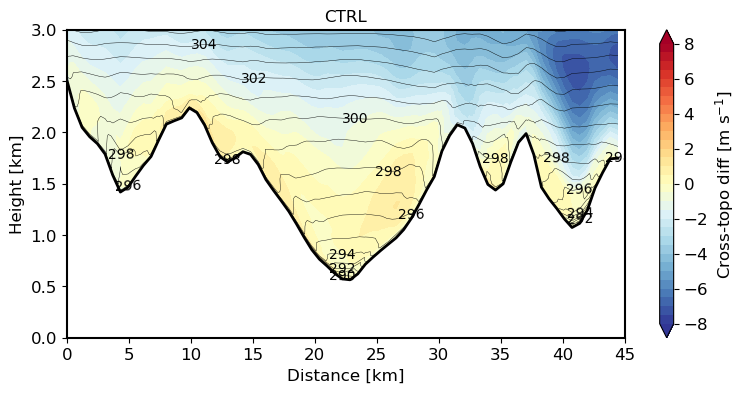

In [22]:
## PLOT SINGLE VCS ##
# general settings
# pvar = vf.T

# pdate1 = dt.datetime(2019,9,13,3,00)
# loc1= pc_dict['kols']
# pdate2 = dt.datetime(2019,9,13,2,00)
# loc2= pc_dict['ifl']

# # plotsettings
# xmin=285
# xmax=315
# ymin=400
# ymax=4000
# xdelticks=5

# Plotting single frame
fig,ax=plt.subplots(figsize=(9, 4))
cmap = 'RdYlBu_r'
fontsize=12
title = 'CTRL'

#-- def x-2d array
x_vert = np.linspace(0, dim_theta[0]-1, dim_theta[0])
xx = np.meshgrid(cross_x_ctrl[:,1], x_vert)
aa =np.asarray(xx[0])
#As all are regridded in the same grid, we only define this once for all plots

levels_th = range(280, 320, 1)
levels_wind = np.arange(-8, 8.5, 0.5)
#levels_wind = np.arange(-.5, .5, 0.005)
#
#-- plotting 
wind_plot = ax.contourf(aa[:-1,:-1],regrid_z_ctrl[:-1,1:],-regrid_wind_ctrl[:-1,1:]
                        ,extend='both',levels=levels_wind/1,cmap=cmap)
th_plot = ax.contour(aa[:-1,:-1],regrid_z_ctrl[:-1,1:],regrid_temp_ctrl[:-1,1:]
                     ,levels=levels_th,colors='k',linewidths=0.30)
ax.clabel(th_plot, levels_th[::2], inline=1, fontsize=10)
#--plot terrain
ter_line = ax.plot(aa[0,:-1],(ter_ctrl[1:]+10)/1000,color='k',linewidth=2) #the +10 is because of the vertical grid resolution

#-- Colorbar
cbar = fig.colorbar(wind_plot)
cbar.ax.tick_params(labelsize='large')
cbar.set_label('Cross-topo diff [m s$^{-1}$]', rotation=90,fontsize=fontsize)

#-- axis settings
ax.set_xlim(0,line.dist)
ax.set_ylim(0,3)
plt.setp(ax.get_xticklabels(),fontsize=fontsize)
plt.setp(ax.get_yticklabels(),fontsize=fontsize)

#-- titles
ax.set_ylabel('Height [km]',fontsize=fontsize)
ax.set_xlabel('Distance [km]',fontsize=fontsize)
ax.set_title(title,fontsize=fontsize)

#-- Pic frame
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
    
#-- maximize and save the pdf file
plt.savefig(fig_name, bbox_inches='tight',dpi=300)